In this notebook, we will be examining the sales data (alongside other additional data) of the line of Favorita stores located in Ecuador, and make predictions of sales down the time series. We will start by looking at each of the data sets and intepreting them as required.

# Preparing Training/Validation Data


In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [170]:
train = pd.read_csv('train.csv', delimiter=',') # training set
hol_events = pd.read_csv('holidays_events.csv', delimiter=',') # holidays in Ecuador
oil = pd.read_csv('oil.csv', delimiter=',') # daily oil prices
trans = pd.read_csv('transactions.csv', delimiter=',') # transactions done in each store each day
stores = pd.read_csv('stores.csv', delimiter=',') # store data

In [3]:
print(train.isna().sum())
print(hol_events.isna().sum())
print(oil.isna().sum())
print(trans.isna().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
date           0
dcoilwtico    43
dtype: int64
date            0
store_nbr       0
transactions    0
dtype: int64


In [171]:
oil['date'] = oil['date'].astype('datetime64')
train['date'] = train['date'].astype('datetime64')
hol_events['date'] = hol_events['date'].astype('datetime64')
combined = train.merge(oil, on='date', how='left')
combined = combined.merge(hol_events, on='date', how='left')

In [172]:
# check the number of rows with no oil price value
combined[combined['dcoilwtico'].isna()]['date'].value_counts().sum()/combined.shape[0]


0.31271878646441076

We see from the above that the number of rows with missing oil data is 31% of the combined dataset, which is significant. We do not want to remove these rows to avoid losing data, so we will attempt to interpolate and get their values.

Clearly, our date has a complicated structure across various time periods, and hence we cannot use simple summary statistics to fill in the data. In this case, we make use of spline interpolation to build piecewise functions and fit them onto the various time periods, and use that function to interpolate the missing data. To do so, we will first need to convert our date into floats, and we do this by setting the first row's date as day 0, and let every subsequent row's day be defined relative to it.

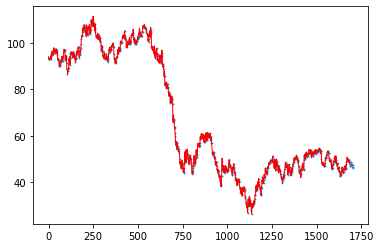

In [173]:
from scipy.interpolate import *


def date_to_days(date):
    """function to convert datetime to days"""
    START_DATE = oil['date'][0]
    return (date - START_DATE).days


oil['days'] = oil['date'].apply(date_to_days)


x = oil[oil['dcoilwtico'].isna() == False]['days'].to_numpy()
y = oil[oil['dcoilwtico'].isna() == False]['dcoilwtico'].to_numpy()
BANDWIDTH = 0 # 0 to force strict interpolation between points

# interpolate by spline interpolation on the points that have non-NaN values
tck = splrep(x, y, s=BANDWIDTH)
xnew = combined['date'].astype('datetime64').apply(date_to_days).to_numpy() # we want to get the interpolated values for all the dates in train
ynew = splev(xnew, tck,)

combined['dcoilwtico'] = ynew #replace column with interpolated values

fig, ax = plt.subplots()
ax.scatter(x, y, s=0.5)
ax.plot(xnew, ynew, 'r-', linewidth=1)
plt.show()

A cursory glance at the training dataset also shows that there is an inordinate amount of 0.0 sales in the certain dates of the training data. Let us examine it closely.

In [7]:
# check the rows with 0 sales

train[train['sales'] == 0.0].loc[:, ['date', 'sales']].value_counts()

date        sales
2013-01-01  0.0      1765
2015-01-01  0.0      1759
2017-01-01  0.0      1754
2016-01-01  0.0      1753
2014-01-01  0.0      1732
                     ... 
2017-05-13  0.0       201
2017-04-30  0.0       199
2017-05-07  0.0       199
2017-05-01  0.0       195
2017-05-06  0.0       194
Length: 1684, dtype: int64

Clearly, we see that since for each date with 0 sales, there are multiple rows associated with it, which indicate that either several stores or families of items were affected by the same factor. Looking at the dates with the biggest number of zero sales, we can quickly conclude by eye that holidays like 'New Years' probably led to store closures etc which led to zero sales too.

Next, we try and make sense of the locale_names (hol_events) and city + state (stores) values. From glancing at the values, we note that the 'locale' actually refers to the cities/states of the stores. If the locale value is regional, locale name is a province/state. If locale value is local, locale name is a city.

We now bring in the store information (city/state) by left joining on the store number columns.

In [174]:
combined = combined.merge(stores, how='left', on='store_nbr')
print(combined.isna().sum())

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico           0
type_x         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
city                 0
state                0
type_y               0
cluster              0
dtype: int64


In [175]:
# fill in days with date_to_day function

START_DATE = combined['date'].min()

def date_to_days(date):
    """function to convert datetime to days"""
    global START_DATE
    return (date - START_DATE).days

combined['days'] = combined['date'].apply(date_to_days)

We note that some of the holidays indicated in the combined table are inaccurate, as some holidays are local/regional rather than national, and hence do not affect all the stores on that particular date. 

We will first replace the 'Bridge' and 'Additional' values with 'Holiday' by assuming that they function the same as a normal holiday. We will then have to clean up the transferred holidays: we need to remove the 'Holiday' tag from the holidays that were transferred to another date, and replace the 'Transfer' tags with 'Holiday' tags to those new replacement dates. 

In [176]:
# replace nans with Work Day since if no holiday typex, means no holiday at all for that date.
combined['type_x'].fillna('Work Day', inplace=True)

# replace Bridge, and Additional with Holiday
replace_dict = {'Bridge': 'Holiday', 'Additional': 'Holiday',}
combined['type_x'].replace(replace_dict, inplace=True)

# replace 'transferred' Holidays with 'Work Day'
combined.loc[combined['transferred'] == True, 'type_x'] = combined.loc[combined['transferred'] == True, 'type_x'].replace({'Holiday': 'Work Day'})

# replace 'Transfer' with 'Holiday'
combined['type_x'].replace({'Transfer': 'Holiday'}, inplace=True)


We will need to change the 'Holiday' value to 'Work Day' for those stores that are outside the region affected by the holiday. By a painstaking process of googling the locale_name values, we notice that the locale_names associated to 'Local' locales are all cities, and the ones associated to 'Regional' are all states. Hence, we can do this validation by checking against the state and city columns.

In [11]:
combined.loc[:, ['locale','locale_name']].value_counts()

locale    locale_name                   
National  Ecuador                           261954
Local     Guayaquil                          19602
          Riobamba                           17820
          Guaranda                           16038
          Latacunga                          16038
          Ambato                             14256
          Quito                              14256
          Cuenca                             10692
          Puyo                                8910
Regional  Imbabura                            8910
          Cotopaxi                            8910
Local     Santo Domingo                       8910
          Manta                               8910
          Cayambe                             8910
          Machala                             8910
          Libertad                            8910
          Esmeraldas                          8910
          El Carmen                           8910
          Quevedo                        

In [177]:
def remove_wrong_hol(row):
    holiday_region = row['locale'] # check if the holiday is local, regional, or national
    if holiday_region == 'Local': # if local, holiday is only applicable to a city
        row_city = row['city']
        hol_city = row['locale_name']
        if row_city != hol_city: # check if the store in the row is in the same city as the holiday
            return 'NA' # if not, then holiday is not applicable, so NA
        else:
            return 'holiday'
    
    elif holiday_region == 'Regional': # if regional, holiday is applicable to whole state
        row_state = row['state']
        hol_state = row['locale_name']
        if row_state != hol_state: # check if the store in the row is in the same state as the holiday
            return 'NA'
        else:
            return 'holiday'
            
    elif holiday_region == 'National':
        return 'holiday'
        
    else: # if no holiday on that day, its jsut a normal work day so NA
        return 'NA'


combined['holiday_cleaned'] = combined.apply(remove_wrong_hol, axis=1)


In [178]:
# check that only the rows with locale_name == state or city has 'holiday'
print(combined[(combined['locale_name'] == combined['state']) | (combined['locale_name'] == combined['city'])]['holiday_cleaned'].value_counts())
print(combined[(combined['locale_name'] != combined['state']) & (combined['locale_name'] != combined['city']) & (combined['locale'] != 'National')]['holiday_cleaned'].value_counts())

holiday    13530
Name: holiday_cleaned, dtype: int64
NA    2778864
Name: holiday_cleaned, dtype: int64


Now, we will split the date data into Years, Months, and Days.

In [179]:
# split date

combined['day'] = combined['date'].dt.day
combined['month'] = combined['date'].dt.month
combined['year'] = combined['date'].dt.year

Now that all the NaNs have been filled in, let's encode them and take a look at the correlations between columns.

In [180]:
# encode family

families = list(combined['family'].unique())
family_codes = {} # family encoding dict
for i in range(len(families)):
    family_codes[families[i]] = i
combined['family'].replace(family_codes, inplace=True)

# # encode holiday Type
# types = list(combined['type_x'].unique())
# type_codes = {} # Type encoding dict
# for i in range(len(types)):
#     type_codes[types[i]] = i 
# combined['type_x'].replace(type_codes, inplace=True)

# # encode locale
# locales = list(combined['locale'].unique())
# locale_codes = {}
# for i in range(len(locales)):
#     locale_codes[locales[i]] = i
# combined['locale'].replace(locale_codes, inplace=True)

# # encode locale_name
# locale_names = list(combined['locale_name'].unique())
# localename_codes = {}
# for i in range(len(locale_names)):
#     localename_codes[locale_names[i]] = i
# combined['locale_name'].replace(localename_codes, inplace=True)

# encode cities
cities = list(combined['city'].unique())
city_codes = {}
for i in range(len(cities)):
    city_codes[cities[i]] = i
combined['city'].replace(city_codes, inplace=True)

# encode states
states = list(combined['state'].unique())
state_codes = {}
for i in range(len(states)):
    state_codes[states[i]] = i
combined['state'].replace(state_codes, inplace=True)

# encode type_y
ytypes = list(combined['type_y'].unique())
y_codes = {}
for i in range(len(ytypes)):
    y_codes[ytypes[i]] = i
combined['type_y'].replace(y_codes, inplace=True)

# encode holiday_cleaned
holidays = list(combined['holiday_cleaned'].unique())
holiday_codes = {}
for i in range(len(holidays)):
    holiday_codes[holidays[i]] = i
combined['holiday_cleaned'].replace(holiday_codes, inplace=True)

In [38]:
print(combined.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 21 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   date             datetime64[ns]
 2   store_nbr        int64         
 3   family           int64         
 4   sales            float64       
 5   onpromotion      int64         
 6   dcoilwtico       float64       
 7   type_x           object        
 8   locale           object        
 9   locale_name      object        
 10  description      object        
 11  transferred      object        
 12  city             int64         
 13  state            int64         
 14  type_y           int64         
 15  cluster          int64         
 16  days             int64         
 17  holiday_cleaned  int64         
 18  day              int64         
 19  month            int64         
 20  year             int64         
dtypes: datetime64[ns](1), float64(2

We will look at the correlations between various columns to see which columns are important for our training dataset.

In [39]:
combined.corr().where((combined.corr() > 0.2) | (combined.corr() < -0.2))

,id,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_y,cluster,days,holiday_cleaned,day,month,year
id,1.000000,NaN,NaN,NaN,0.206032,-0.838719,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.977741
store_nbr,NaN,1.000000,NaN,NaN,NaN,NaN,0.588676,0.587449,0.571970,NaN,NaN,NaN,NaN,NaN,NaN
family,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,NaN,NaN,NaN,1.000000,0.428241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
onpromotion,0.206032,NaN,NaN,0.428241,1.000000,NaN,NaN,NaN,NaN,NaN,0.206016,NaN,NaN,NaN,NaN
dcoilwtico,-0.838719,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,-0.838762,NaN,NaN,NaN,-0.833454
city,NaN,0.588676,NaN,NaN,NaN,NaN,1.000000,0.985210,NaN,-0.423020,NaN,NaN,NaN,NaN,NaN
state,NaN,0.587449,NaN,NaN,NaN,NaN,0.985210,1.000000,NaN,-0.416731,NaN,NaN,NaN,NaN,NaN
type_y,NaN,0.571970,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.388057,NaN,NaN,NaN,NaN,NaN
cluster,NaN,NaN,NaN,NaN,NaN,NaN,-0.423020,-0.416731,0.388057,1.000000,NaN,NaN,NaN,NaN,NaN


# Creating and optimising MLP DNN via PyTorch

Now that we have prepared our data and encoded all of them, we will try creating to train a supervised neural network on a training set (80% of our combined data), and validate it on the validation set (20% of combined data). We use sklearn's train_test_split function to first prep the data.

In [68]:
import torch
import torch.nn as nn

# define the neural network

class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(11, 11),
        nn.LeakyReLU(),
        nn.Linear(11, 32),
        nn.LeakyReLU(),
        nn.Linear(32, 1)
        )
    
    def forward(self, x):
        """forward pass"""
        return self.layers(x)
    


In [69]:
# prepare input data for neural network

INPUT_COLS = ['day', 'month', 'store_nbr', 'family', 'onpromotion', 
              'dcoilwtico', 'city', 'state', 'type_y', 'cluster', 
              'holiday_cleaned', 'sales']

TESTING_SIZE = 100000

from sklearn.model_selection import train_test_split

train, test = train_test_split(combined.loc[:TESTING_SIZE, INPUT_COLS], test_size=0.3, random_state=69)
print(train.shape, test.shape)

# create class for loading our pandas dataset

class CombinedDataset(torch.utils.data.Dataset):
    
    def __init__(self, X, y, scale_data=False):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                scale_factor = 1/(X.max()-X.min())
                X = (X-X.min())*scale_factor
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# load our df dataset into tensor for pytorch

X = train.iloc[:, :-1].to_numpy()
y = train.iloc[:, -1].to_numpy()

X_test = test.iloc[:, :-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy()

BATCH_SIZE = 256

dataset = CombinedDataset(X=X, y=y)
dataset_test = CombinedDataset(X=X_test, y=y_test)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE)

(70000, 12) (30001, 12)


In [ ]:
# Initialize the MLP
# mlp = MLP()

# Set fixed random number seed
torch.manual_seed(42)


# Define the loss function and optimizer
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

class MinMaxScaler(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, tensor):
        return (tensor - torch.min(tensor))/(torch.max(tensor) - torch.min(tensor))
    
loss_function = RMSLELoss()

minmax = MinMaxScaler()

losses_epoch = []
test_losses_epoch = []


In [131]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.0005,)

In [135]:
# Run the training loop
for epoch in range(0, 500): # 100 epochs at maximum

    # Print epoch
    print(f'Starting epoch {epoch+1}', end='\r')

    # Set current loss value
    losses = []
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get and prepare inputs

        inputs, targets = data
        
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = mlp(inputs)
        
        # Compute loss
        loss = loss_function(minmax(outputs), minmax(targets))

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        losses.append(loss.detach())
        
    losses_epoch.append(losses)
    
    # Set current test_losses
    test_losses = []

    for i, data in enumerate(testloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # 予測計算
        outputs = mlp(inputs)

        #値の制限 下限を０
        #outputs = torch.clamp(input=outputs, min= 0)

        # 損失計算
        test_loss = loss_function(minmax(outputs), minmax(targets))
        test_losses.append(test_loss.detach())

    test_losses_epoch.append(test_losses)      
 
# Process is complete.
print('Training process has finished.')

Training process has finished.


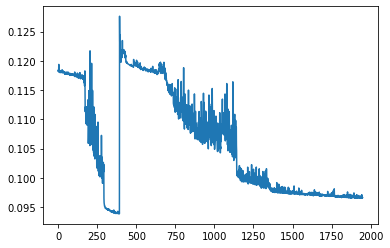

In [136]:
loss_x = []

for epoch in losses_epoch:
    loss_x.append(sum(epoch)/len(epoch))

plt.plot(loss_x[:])


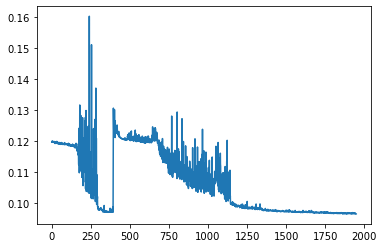

In [137]:
test_loss_x = []

for epoch in test_losses_epoch:
    test_loss_x.append(sum(epoch)/len(epoch))
    
plt.plot(test_loss_x[:])

In [138]:
torch.save(mlp.state_dict(), 'store_sales_model.pt')

# Applying Model to Test Data

Now that our model is ready, we load our test data and process it in the same way, before putting it through the model.

In [157]:
test = pd.read_csv('test.csv', delimiter=',') # loading test data

In [158]:
oil['date'] = oil['date'].astype('datetime64')
test['date'] = test['date'].astype('datetime64')
hol_events['date'] = hol_events['date'].astype('datetime64')
combined_test = test.merge(oil, on='date', how='left')
combined_test = combined_test.merge(hol_events, on='date', how='left')

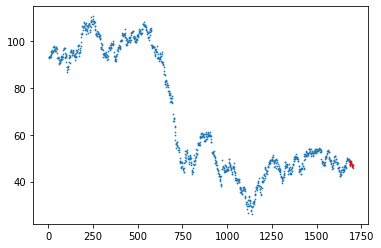

In [159]:
from scipy.interpolate import *


def date_to_days(date):
    """function to convert datetime to days"""
    START_DATE = oil['date'][0]
    return (date - START_DATE).days


oil['days'] = oil['date'].apply(date_to_days)


x = oil[oil['dcoilwtico'].isna() == False]['days'].to_numpy()
y = oil[oil['dcoilwtico'].isna() == False]['dcoilwtico'].to_numpy()
BANDWIDTH = 0 # 0 to force strict interpolation between points

# interpolate by spline interpolation on the points that have non-NaN values
tck = splrep(x, y, s=BANDWIDTH)
xnew = combined_test['date'].astype('datetime64').apply(date_to_days).to_numpy() # we want to get the interpolated values for all the dates in test
ynew = splev(xnew, tck,)

combined_test['dcoilwtico'] = ynew #replace column with interpolated values

fig, ax = plt.subplots()
ax.scatter(x, y, s=0.5)
ax.plot(xnew, ynew, 'r-', linewidth=1)
plt.show()


In [160]:
combined_test = combined_test.merge(stores, how='left', on='store_nbr')
print(combined_test.isna().sum())


id                 0
date               0
store_nbr          0
family             0
onpromotion        0
dcoilwtico         0
days            7128
type_x         26730
locale         26730
locale_name    26730
description    26730
transferred    26730
city               0
state              0
type_y             0
cluster            0
dtype: int64


In [161]:
# fill in days with date_to_day function

START_DATE = combined_test['date'].min()

def date_to_days(date):
    """function to convert datetime to days"""
    global START_DATE
    return (date - START_DATE).days

combined_test['days'] = combined_test['date'].apply(date_to_days)

In [162]:
# replace nans with Work Day since number of work days is low (5)
combined_test['type_x'].fillna('Work Day', inplace=True)

# replace Bridge, and Additional with Holiday
replace_dict = {'Bridge': 'Holiday', 'Additional': 'Holiday',}
combined_test['type_x'].replace(replace_dict, inplace=True)

# replace 'transferred' Holidays with 'Work Day'
combined_test.loc[combined_test['transferred'] == True, 'type_x'] = combined_test.loc[combined_test['transferred'] == True, 'type_x'].replace({'Holiday': 'Work Day'})

# replace 'Transfer' with 'Holiday'
combined_test['type_x'].replace({'Transfer': 'Holiday'}, inplace=True)


In [163]:
combined_test['holiday_cleaned'] = combined_test.apply(remove_wrong_hol, axis=1)


In [164]:
# split date

combined_test['day'] = combined_test['date'].dt.day
combined_test['month'] = combined_test['date'].dt.month
combined_test['year'] = combined_test['date'].dt.year

In [181]:
# encode family
combined_test['family'].replace(family_codes, inplace=True)

# # encode holiday Type
# types = list(combined_test['type_x'].unique())
# type_codes = {} # Type encoding dict
# for i in range(len(types)):
#     type_codes[types[i]] = i 
# combined_test['type_x'].replace(type_codes, inplace=True)

# # encode locale
# locales = list(combined_test['locale'].unique())
# locale_codes = {}
# for i in range(len(locales)):
#     locale_codes[locales[i]] = i
# combined_test['locale'].replace(locale_codes, inplace=True)

# # encode locale_name
# locale_names = list(combined_test['locale_name'].unique())
# localename_codes = {}
# for i in range(len(locale_names)):
#     localename_codes[locale_names[i]] = i
# combined_test['locale_name'].replace(localename_codes, inplace=True)

# encode cities
combined_test['city'].replace(city_codes, inplace=True)

# encode states
combined_test['state'].replace(state_codes, inplace=True)

# encode type_y
combined_test['type_y'].replace(y_codes, inplace=True)

# encode holiday_cleaned
combined_test['holiday_cleaned'].replace(holiday_codes, inplace=True)

In [182]:
print(state_codes)

{'Pichincha': 0, 'Cotopaxi': 1, 'Chimborazo': 2, 'Imbabura': 3, 'Santo Domingo de los Tsachilas': 4, 'Bolivar': 5, 'Pastaza': 6, 'Tungurahua': 7, 'Guayas': 8, 'Santa Elena': 9, 'Los Rios': 10, 'Azuay': 11, 'Loja': 12, 'El Oro': 13, 'Esmeraldas': 14, 'Manabi': 15}


In [183]:
print(combined_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28512 entries, 0 to 28511
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               28512 non-null  int64         
 1   date             28512 non-null  datetime64[ns]
 2   store_nbr        28512 non-null  int64         
 3   family           28512 non-null  int64         
 4   onpromotion      28512 non-null  int64         
 5   dcoilwtico       28512 non-null  float64       
 6   days             28512 non-null  int64         
 7   type_x           28512 non-null  object        
 8   locale           1782 non-null   object        
 9   locale_name      1782 non-null   object        
 10  description      1782 non-null   object        
 11  transferred      1782 non-null   object        
 12  city             28512 non-null  int64         
 13  state            28512 non-null  int64         
 14  type_y           28512 non-null  int64

In [184]:
# prepare input data for neural network


# load our df dataset into tensor for pytorch
SUB_COLS = ['day', 'month', 'store_nbr', 'family', 'onpromotion', 
              'dcoilwtico', 'city', 'state', 'type_y', 'cluster', 
              'holiday_cleaned', ]

X_sub = combined_test.loc[:, SUB_COLS].to_numpy()

class SubDataset(torch.utils.data.Dataset):
    
    def __init__(self, X, scale_data=False):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i]


SUB_BATCH_SIZE = 1
        
dataset_sub = SubDataset(X=X_sub)
subloader = torch.utils.data.DataLoader(dataset_sub, batch_size=SUB_BATCH_SIZE)

# # Initialize the MLP
# mlp = MLP()

loss_function = RMSLELoss()
minmax = MinMaxScaler()

# Set current test_losses
output_list = []

for i, data in enumerate(subloader, 0):
    inputs = data
    inputs = inputs.float()
    
    # 予測計算
    outputs = mlp(inputs)

    #値の制限 下限を０
    #outputs = torch.clamp(input=outputs, min= 0)

    output_list.append(outputs.detach().numpy())
    
    print(f'Data Row {i}', end='\r')
    
# Process is complete.
print('Prediction has finished.')

Prediction has finished.


In [185]:
sales = np.array(output_list).reshape([28512,])

In [186]:
submission_table = combined_test
submission_table['sales'] = sales

In [ ]:
submission_table.loc[:, ['id', 'sales']].to_csv('Submission v1.csv', index=False)

# End

We have finished running our simple MLP model on a real-world time-series data. Clearly, the results are not optimised. Many of the columns we used for our training X have little correlation with the sales column, and we could possibly have found better features either by creating new columns from the existing columns, or perhaps doing feature extraction via PCA.

One learning point from this was that by varying the learning rate across epochs, I was able to prevent the data from oscillating around local minima by reducing the learning rate when fluctuations are large.

We will take a step back and do more analysis on the data itself, and attempt to visualise the data via plotly's interactive graphing functions.